In [1]:
import json
import h5py
import tqdm
import datetime
import time
import pandas as pd
import numpy as np
import os
from scipy import stats

import importlib
import sys
sys.path.insert(0, '/cndd/fangming/CEMBA/snmcseq_dev')
sys.path.insert(0, '/cndd2/fangming/projects/SingleCellRoutines')

import __init__plots
importlib.reload(__init__plots)
from __init__plots import *

import snmcseq_utils
importlib.reload(snmcseq_utils)

import utils
importlib.reload(utils)




<module 'utils' from '/cndd2/fangming/projects/SingleCellRoutines/utils.py'>

# count matrices

In [2]:
# palette as json
file = '../data/palette.json'
with open(file, 'r') as f:
    palette = json.load(f)
palette

{'Slice1_Replicate1': [0.19215686274509805,
  0.5098039215686274,
  0.7411764705882353],
 'Slice1_Replicate2': [0.4196078431372549,
  0.6823529411764706,
  0.8392156862745098],
 'Slice1_Replicate3': [0.6196078431372549,
  0.792156862745098,
  0.8823529411764706],
 'Slice2_Replicate1': [0.9019607843137255,
  0.3333333333333333,
  0.050980392156862744],
 'Slice2_Replicate2': [0.9921568627450981,
  0.5529411764705883,
  0.23529411764705882],
 'Slice2_Replicate3': [0.9921568627450981,
  0.6823529411764706,
  0.4196078431372549],
 'Slice3_Replicate1': [0.19215686274509805,
  0.6392156862745098,
  0.32941176470588235],
 'Slice3_Replicate2': [0.4549019607843137,
  0.7686274509803922,
  0.4627450980392157],
 'Slice3_Replicate3': [0.6313725490196078,
  0.8509803921568627,
  0.6078431372549019]}

In [3]:
# metadata
file = '../data/processed_vizgen_merfish_may1_2021.h5ad'
samples = [
    'Slice1_Replicate1',
    'Slice1_Replicate2',
    'Slice1_Replicate3',
    
    'Slice2_Replicate1',
    'Slice2_Replicate2',
    'Slice2_Replicate3',
    
    'Slice3_Replicate1',
    'Slice3_Replicate2',
    'Slice3_Replicate3',
]

metas = {}
for sample in samples:
    meta = pd.read_hdf(file, 'data_'+sample).iloc[:,:11]
    metas[sample] = meta 
    print(meta.shape, meta.columns)

(78329, 11) Index(['x', 'y', 'fov', 'volume', 'center_x', 'center_y', 'min_x', 'max_x',
       'min_y', 'max_y', 'cell_cov'],
      dtype='object')
(88884, 11) Index(['x', 'y', 'fov', 'volume', 'center_x', 'center_y', 'min_x', 'max_x',
       'min_y', 'max_y', 'cell_cov'],
      dtype='object')
(84636, 11) Index(['x', 'y', 'fov', 'volume', 'center_x', 'center_y', 'min_x', 'max_x',
       'min_y', 'max_y', 'cell_cov'],
      dtype='object')
(83546, 11) Index(['x', 'y', 'fov', 'volume', 'center_x', 'center_y', 'min_x', 'max_x',
       'min_y', 'max_y', 'cell_cov'],
      dtype='object')
(84172, 11) Index(['x', 'y', 'fov', 'volume', 'center_x', 'center_y', 'min_x', 'max_x',
       'min_y', 'max_y', 'cell_cov'],
      dtype='object')
(85958, 11) Index(['x', 'y', 'fov', 'volume', 'center_x', 'center_y', 'min_x', 'max_x',
       'min_y', 'max_y', 'cell_cov'],
      dtype='object')
(70844, 11) Index(['x', 'y', 'fov', 'volume', 'center_x', 'center_y', 'min_x', 'max_x',
       'min_y', 'max_y',

In [4]:
# raw counts
DATA_DIR = '/datasets/Public_Datasets/Vizgen_MERFISH_mouse_brain'
data_dir = DATA_DIR

slicenames = [
    "Slice1",
    "Slice2",
    "Slice3",
]
replicates = [
    "Replicate1",
    "Replicate2",
    "Replicate3",
]
ti = time.time()

allcounts = {}

i = 0
for slicename in slicenames:
    for replicate in replicates:
        sample_name = '{}_{}'.format(slicename, replicate)
        print(sample_name)
        fdata = os.path.join(data_dir, '{}/{}/cell_by_gene.csv'.format(slicename, replicate))

        # read in
        data = pd.read_csv(fdata, index_col=0)
        data = data.drop(data.filter(regex='^Blank-').columns, axis=1)
        if i == 0:
            genes = data.columns
        else:
            assert np.all(genes == data.columns)
        
        # record
        i += 1
        allcounts[sample_name] = data
        print(time.time()-ti)

Slice1_Replicate1
6.3531177043914795
Slice1_Replicate2
13.695969581604004
Slice1_Replicate3
19.855239152908325
Slice2_Replicate1
26.417441606521606
Slice2_Replicate2
32.495853662490845
Slice2_Replicate3
38.926620960235596
Slice3_Replicate1
44.49005961418152
Slice3_Replicate2
50.919450759887695
Slice3_Replicate3
56.940290212631226


# Processing (planned)

## group1
- remove cells with volume < 100um^3 or > 3*median volume (~1000um^3) 
- normalize counts by imaged volume of each cell 
- normalize mean total RNA counts per cell to a same mean value (250) for each experiment
- remove cells with counts <2% or >98%
- (not done) remove doublets using scrublet

## group2
- normalize the counts for each cell by median of all cells
- log transform

## group3
- z-score for each gene
- PCA for the first 35 PCs
- Louvain using scanpy (bootstrap and optimal k)
- 2 round clustering (redo PCAs and clusterings ...)

# Diagnosis

/cndd2/fangming/venvs/routine/lib/python3.8/site-packages/IPython/core/pylabtools.py:132: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


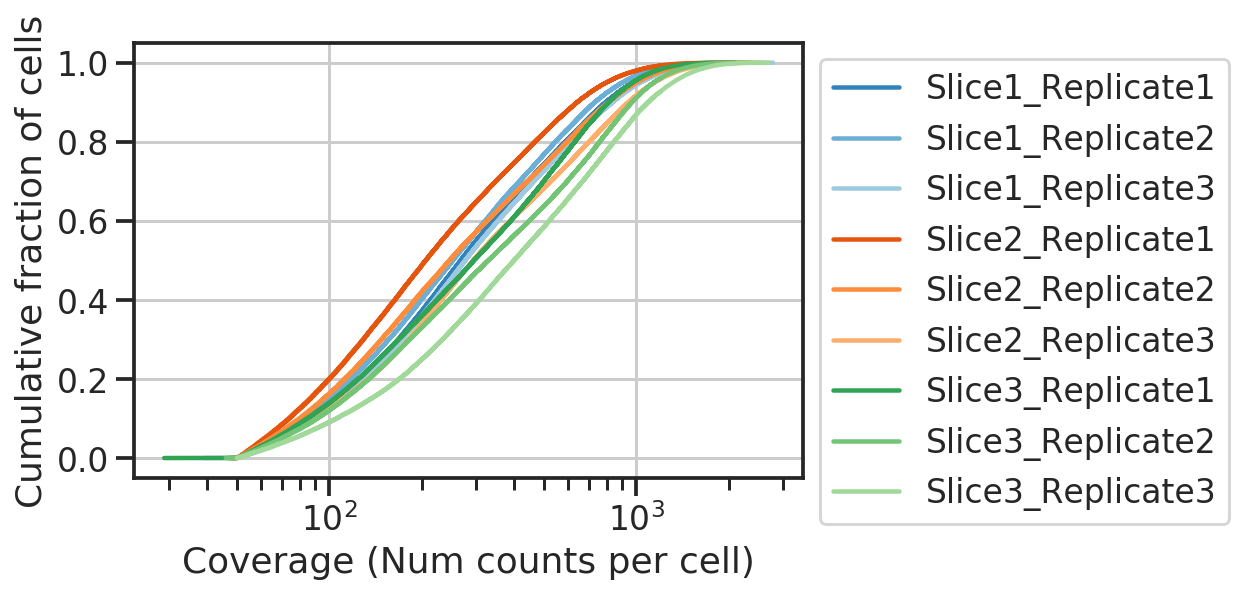

In [5]:
fig, ax = plt.subplots()
for sample in metas.keys():
    color = palette[sample]
    cell_cov = metas[sample]['cell_cov']
    med = cell_cov.median()
    snmcseq_utils.gen_cdf(cell_cov, ax=ax, label=sample, color=color)
    
#     sns.distplot(cell_cov, ax=ax, label=sample_name, color=color, )
#     ax.axvline(med, color=color, linestyle='--')
    
ax.legend(bbox_to_anchor=(1,1))
ax.set_xscale('log')
ax.set_xlabel('Coverage (Num counts per cell)')
ax.set_ylabel('Cumulative fraction of cells')
plt.show()

median: 814.047281751238
median: 674.3683084249567
median: 767.723470068046
median: 792.6348885204034
median: 728.6746705222681
median: 820.5391728880256
median: 839.6616020400609
median: 864.5512379712883
median: 836.7072273267933


/cndd2/fangming/venvs/routine/lib/python3.8/site-packages/IPython/core/pylabtools.py:132: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


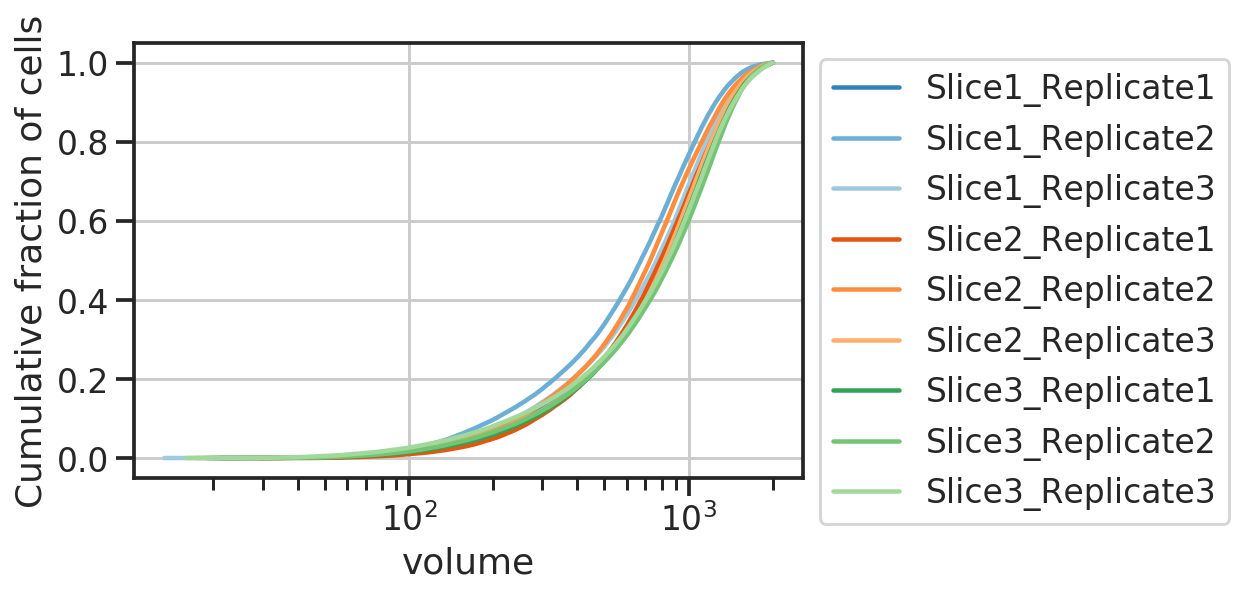

In [6]:
fig, ax = plt.subplots()
for sample in metas.keys():
    color = palette[sample]
    x = 'volume'
    _x = metas[sample][x]
    med = _x.median()
    snmcseq_utils.gen_cdf(_x, ax=ax, label=sample, color=color)
    print("median: {}".format(med))
    
#     sns.distplot(cell_cov, ax=ax, label=sample_name, color=color, )
#     ax.axvline(med, color=color, linestyle='--')
    
ax.legend(bbox_to_anchor=(1,1))
ax.set_xscale('log')
ax.set_xlabel(x)
ax.set_ylabel('Cumulative fraction of cells')
plt.show()

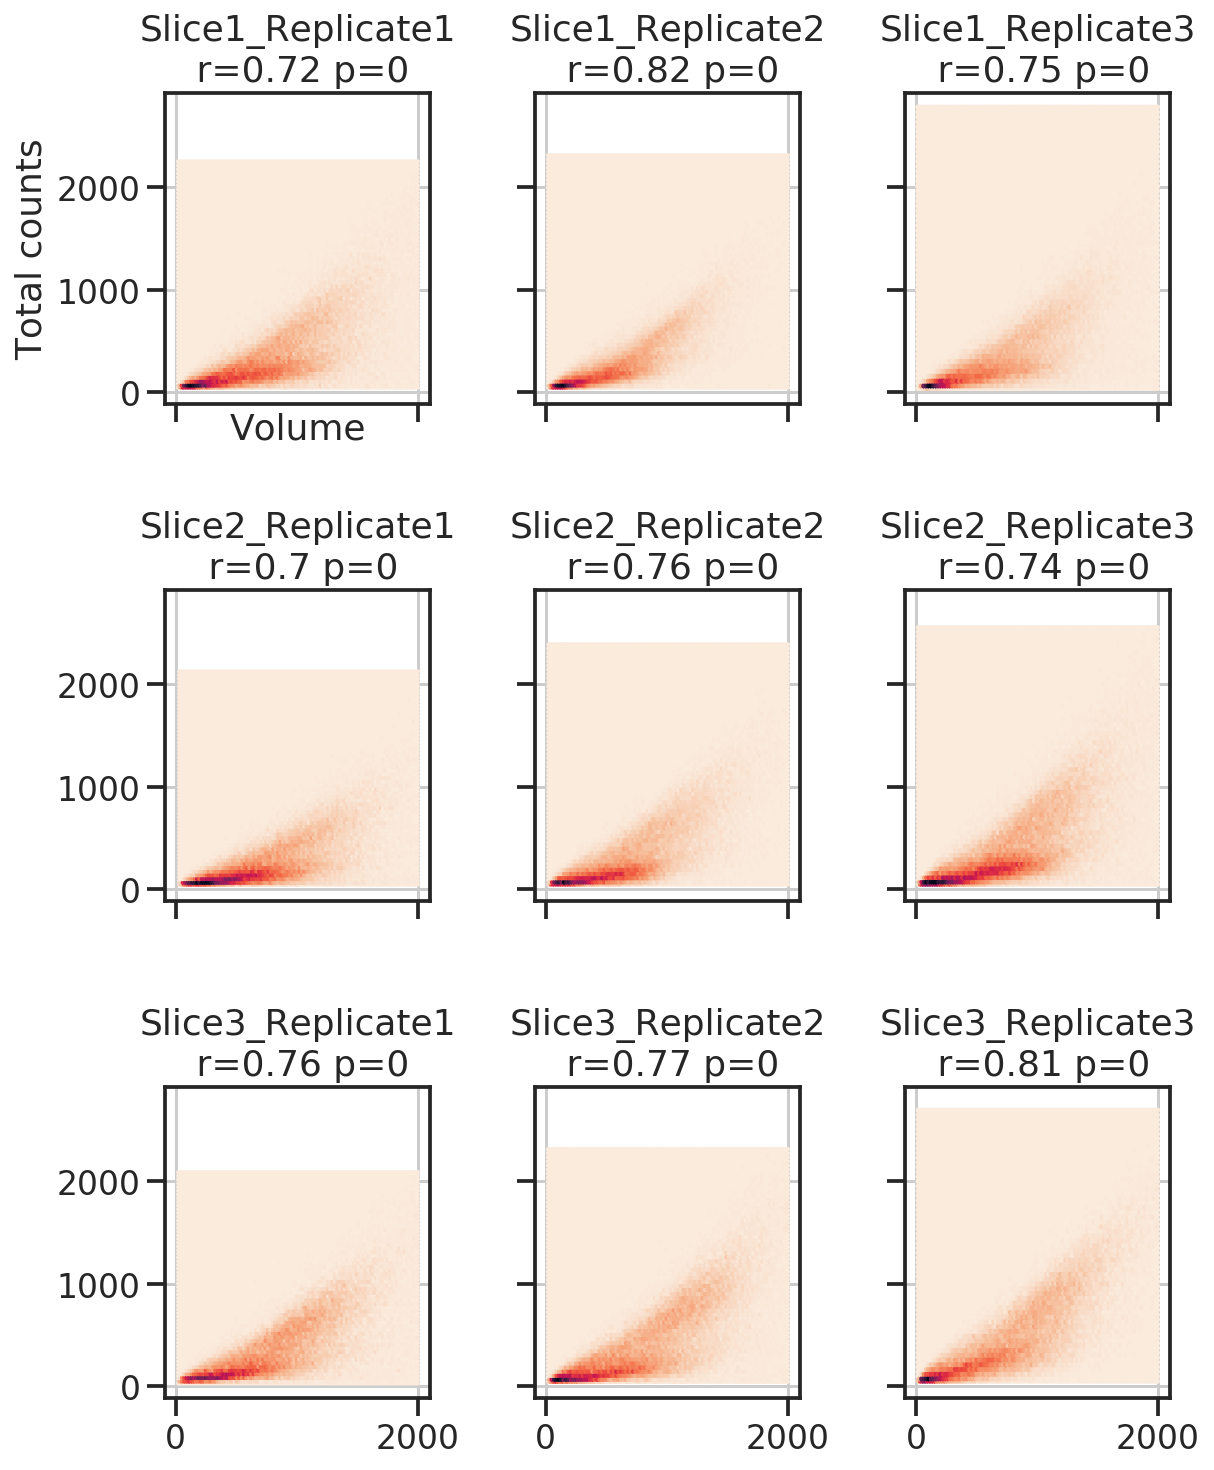

In [7]:
fig, axs = plt.subplots(3,3,figsize=(3*3,3*4), sharex=True, sharey=True)
for i, (sample, ax) in enumerate(zip(metas.keys(), axs.flat)):
    meta = metas[sample]
    color = palette[sample]
    x, y, data = 'volume', 'cell_cov', meta
    ax.hexbin(data[x].values, data[y].values, cmap='rocket_r')
    
    r, p = stats.pearsonr(data[x].values, data[y].values)
    ax.set_title("{}\n r={:.2g} p={:.2g}".format(sample, r, p))
    if i == 0:
        ax.set_xlabel('Volume')
        ax.set_ylabel('Total counts')
    
fig.subplots_adjust(wspace=0.4, hspace=0.6) 
plt.show()

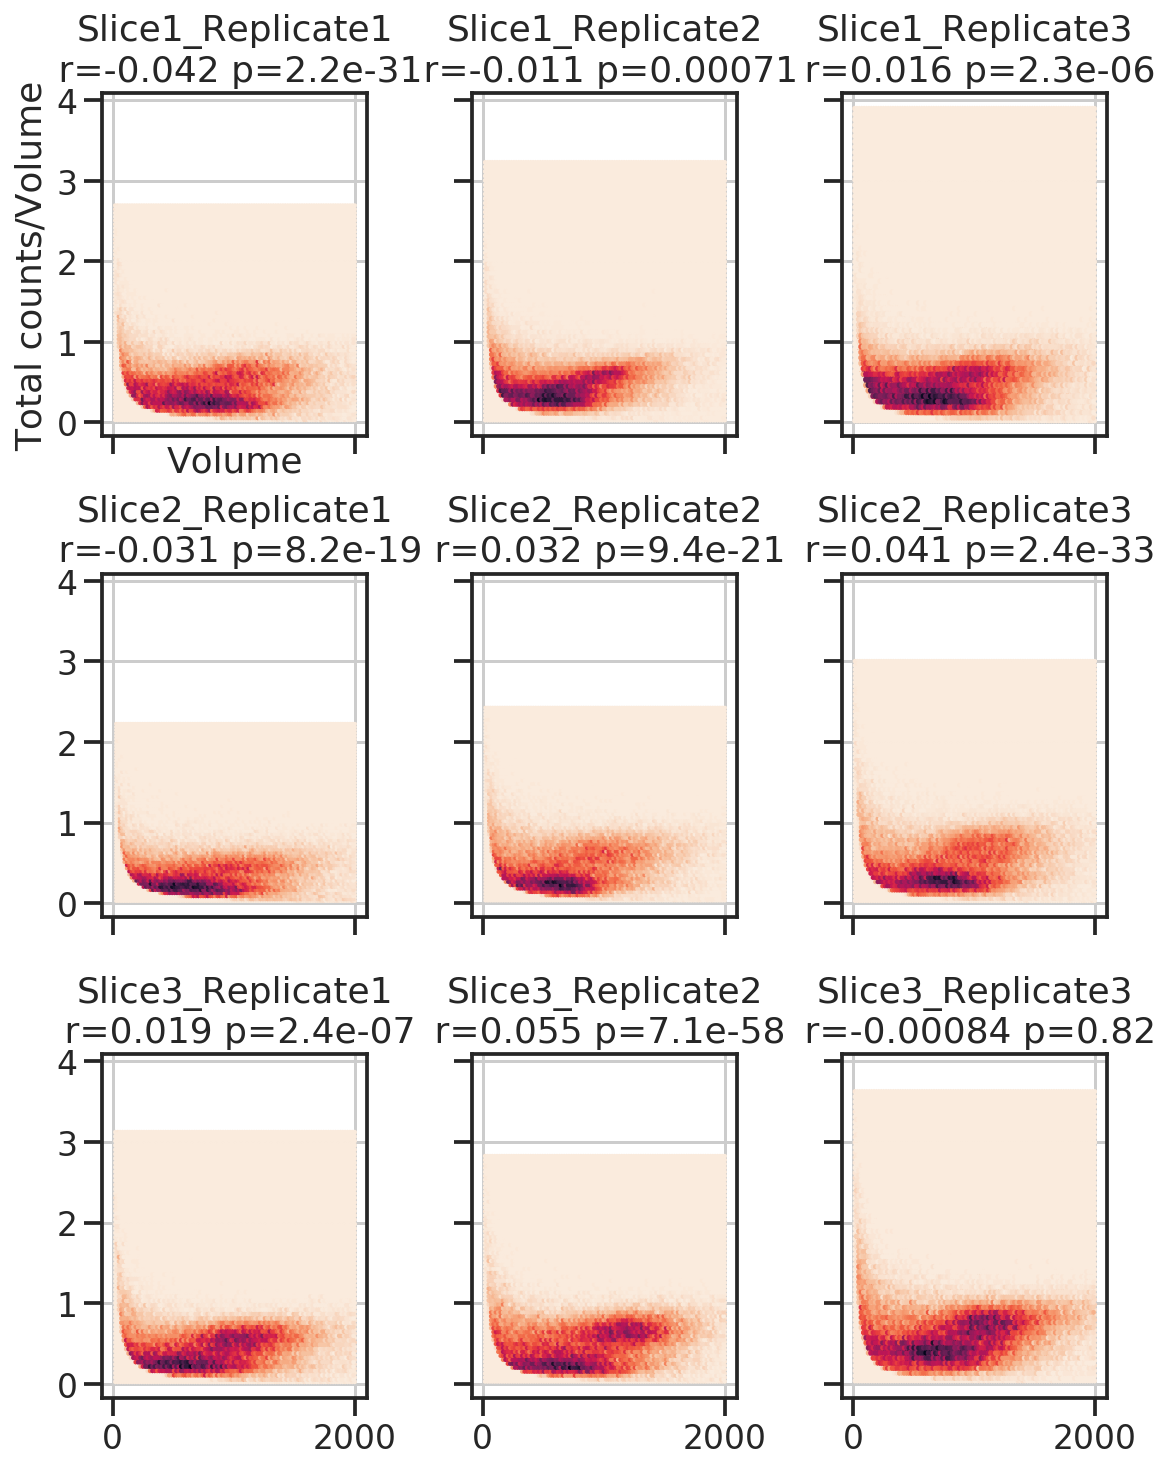

In [8]:
fig, axs = plt.subplots(3,3,figsize=(3*3,3*4), sharex=True, sharey=True)
for i, (sample, ax) in enumerate(zip(metas.keys(), axs.flat)):
    meta = metas[sample]
    color = palette[sample]
    x, y, data = 'volume', 'cell_cov', meta
    ax.hexbin(data[x].values, data[y].values/data[x].values, cmap='rocket_r')
    
    r, p = stats.pearsonr(data[x].values, data[y].values/data[x].values)
    ax.set_title("{}\n r={:.2g} p={:.2g}".format(sample, r, p))
    if i == 0:
        ax.set_xlabel('Volume')
        ax.set_ylabel('Total counts/Volume')
    
fig.subplots_adjust(wspace=0.4, hspace=0.4) 
plt.show()

## Implement processing 

## group1
- remove cells with volume < 100um^3 or > 3*median volume (~1000um^3) 
- normalize counts by imaged volume of each cell 
- remove cells with counts <2% or >98%

## group2
- normalize the counts for each cell by median of all cells
- log transform

In [9]:

import h5py
output = '../data/processed_vizgen_merfish_may22_2021.hdf5'
if os.path.isfile(output):
    os.remove(output)

for sample in metas.keys():
    meta = metas[sample]
    counts = allcounts[sample]
    
    meta_p = meta.copy() #.head(1000)
    counts_p = counts.copy() #.head(1000)
    print(meta_p.shape, counts_p.shape)
    
    # step1 - filter cells based on volumes
    med_vol = meta_p['volume'].median()
    cond1 = (meta_p['volume'] < 100)
    cond2 = (meta_p['volume'] > 3*med_vol)
    print("remove {} cells".format(cond1.sum()))
    print("remove {} cells".format(cond2.sum()))
    meta_p = meta_p[~(cond1 | cond2)]
    counts_p = counts_p.loc[meta_p.index]
    print(meta_p.shape, counts_p.shape)
    
    # step2 - norm counts by volume
    med_vol = meta_p['volume'].median()
    norm_factor = meta_p['volume']/med_vol
    meta_p['cell_cov_norm'] = meta_p['cell_cov']/norm_factor
    counts_p = counts_p.divide(norm_factor, axis=0)
    
    # step3 - remove outliers
    p2 = np.percentile(meta_p['cell_cov_norm'], 2)
    p98 = np.percentile(meta_p['cell_cov_norm'], 98)
    cond3 = (meta_p['cell_cov_norm'] < p2)
    cond4 = (meta_p['cell_cov_norm'] > p98)
    print("remove {} cells".format(cond3.sum()))
    print("remove {} cells".format(cond4.sum()))
    meta_p = meta_p[~(cond3 | cond4)]
    counts_p = counts_p.loc[meta_p.index]
    print(meta_p.shape, counts_p.shape)
    
    # step4 - norm by the median
    med_cov = meta_p['cell_cov_norm'].median()
    norm_factor = meta_p['cell_cov_norm']/med_cov
    counts_p = counts_p.divide(norm_factor, axis=0)
    print("median norm cov {}".format(med_cov))
    
    # step5 - log
    counts_p = np.log10(counts_p+1)
    print(meta_p.shape, counts_p.shape)
    
    # save as hdf5
    meta_p.to_hdf(output, key='meta_'+sample, mode='a')
    counts_p.to_hdf(output, key='mat_'+sample, mode='a')
    
#     break

(78329, 11) (78329, 483)
remove 1242 cells
remove 0 cells
(77087, 11) (77087, 483)
remove 1542 cells
remove 1542 cells
(74003, 12) (74003, 483)
median norm cov 339.76985869273227
(74003, 12) (74003, 483)
(88884, 11) (88884, 483)
remove 2063 cells
remove 0 cells
(86821, 11) (86821, 483)
remove 1737 cells
remove 1737 cells
(83347, 12) (83347, 483)
median norm cov 308.9253046100275
(83347, 12) (83347, 483)
(84636, 11) (84636, 483)
remove 1340 cells
remove 0 cells
(83296, 11) (83296, 483)
remove 1666 cells
remove 1666 cells
(79964, 12) (79964, 483)
median norm cov 354.36630918450237
(79964, 12) (79964, 483)
(83546, 11) (83546, 483)
remove 816 cells
remove 0 cells
(82730, 11) (82730, 483)
remove 1655 cells
remove 1655 cells
(79420, 12) (79420, 483)
median norm cov 257.1187648571171
(79420, 12) (79420, 483)
(84172, 11) (84172, 483)
remove 1601 cells
remove 0 cells
(82571, 11) (82571, 483)
remove 1652 cells
remove 1652 cells
(79267, 12) (79267, 483)
median norm cov 311.31564215391546
(79267, 

In [10]:
with h5py.File(output, 'r') as f:
    print(f.keys())

<KeysViewHDF5 ['mat_Slice1_Replicate1', 'mat_Slice1_Replicate2', 'mat_Slice1_Replicate3', 'mat_Slice2_Replicate1', 'mat_Slice2_Replicate2', 'mat_Slice2_Replicate3', 'mat_Slice3_Replicate1', 'mat_Slice3_Replicate2', 'mat_Slice3_Replicate3', 'meta_Slice1_Replicate1', 'meta_Slice1_Replicate2', 'meta_Slice1_Replicate3', 'meta_Slice2_Replicate1', 'meta_Slice2_Replicate2', 'meta_Slice2_Replicate3', 'meta_Slice3_Replicate1', 'meta_Slice3_Replicate2', 'meta_Slice3_Replicate3']>


In [ ]:
# set output as read only